In [1]:
# This is needed to import the CC and EC Models from this location in this project.
import sys
sys.path.append("../..")

from MagneticFluxRopeModels.ECModel import ECModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.signal import butter, filtfilt

In [2]:
df_wind = pd.read_csv("12-13-june-2005.csv", sep=";")
df_wind = df_wind.drop("Year", axis=1)
df_wind = df_wind.rename(columns={"Bx": "B_x", "By": "B_y", "Bz": "B_z", "Vx": "v_x", "Vy": "v_y", "Vz": "v_z", "Btheta": "B_theta", "Bphi": "B_phi", "Np": "N_p"})
df_wind.head()

,DOY,millisecs,B,B_x,B_y,B_z,B_theta,B_phi,v_x,v_y,v_z,N_p
0,163,199031,7.14,1.05,-7.06,0.04,0.29,278.49,-300.4,-28.2,-18.9,19.3
1,163,297808,6.85,0.25,-6.71,1.22,10.28,272.17,-303.6,-28.3,-15.6,19.2
2,163,390506,6.63,-0.05,-6.47,1.45,12.61,269.55,-302.1,-28.1,-16.9,20.6
3,163,487763,6.57,-0.12,-6.43,1.29,11.33,268.97,-303.8,-28.8,-11.3,19.7
4,163,588094,6.44,-0.45,-6.14,1.87,16.86,265.84,-302.4,-28.2,-16.6,21.3


In [3]:
df_wind.tail()

,DOY,millisecs,B,B_x,B_y,B_z,B_theta,B_phi,v_x,v_y,v_z,N_p
1748,164,85950039,4.25,-4.15,-0.68,-0.37,-5.04,189.35,-448.9,-11.1,-2.0,5.2
1749,164,86049656,4.25,-3.11,-2.33,-1.18,-16.96,216.86,-459.9,19.8,-0.7,4.0
1750,164,86145375,4.40,-2.17,-3.37,-1.58,-21.54,237.20,-456.5,31.7,4.3,4.3
1751,164,86241812,4.46,-2.78,-3.09,-1.52,-20.04,227.97,-449.3,33.8,5.3,4.4
1752,164,86362632,4.54,-2.82,-2.95,-1.95,-25.50,226.28,-370.2,33.4,-287.1,12.0


In [4]:
SEC_TO_HOURS = 3600
SEC_TO_DAYS = 3600 * 24

df_wind["time_sec"] = df_wind["millisecs"] / 1000
df_wind = df_wind.drop("millisecs", axis=1)
df_wind["time_sec"] = df_wind["time_sec"] + (df_wind["DOY"] - df_wind["DOY"][0])*(SEC_TO_DAYS)
df_wind["time_days"] = df_wind["time_sec"] / SEC_TO_DAYS
df_wind = df_wind.drop("DOY", axis=1)

# Just to be sure the time is sorted
df_wind = df_wind.sort_values(by="time_days")

In [5]:
df_wind_resampled = df_wind.copy()
from scipy.interpolate import interp1d

# Define a new uniform time grid
uniform_times = np.linspace(df_wind["time_sec"][0], df_wind["time_sec"][len(df_wind) - 1], len(df_wind), endpoint=True)

# Interpolate the data to the new uniform time grid
for column in df_wind.columns:
    if column != "time_sec" and column != "time_days":
        non_uniform_times = df_wind["time_sec"].values
        signal = df_wind[column].values

        # Check if the signal has NaN values
        if np.any(np.isnan(signal)):
            # Interpolate over NaN values
            mask = ~np.isnan(signal)
            non_uniform_times = non_uniform_times[mask]
            signal = signal[mask]

        # Check if the signal is empty after removing NaN values
        if len(signal) == 0:
            print(f"Warning: {column} has no valid data after removing NaN values.")
            continue

        # Create an interpolation function
        interp_func = interp1d(non_uniform_times, signal, kind="cubic")

        # Interpolate the signal to the new uniform time grid
        resampled_signal = interp_func(uniform_times)
        df_wind_resampled[column] = resampled_signal

df_wind_resampled["time_sec"] = uniform_times
df_wind_resampled["time_days"] = uniform_times / SEC_TO_DAYS

df_wind_resampled.head()

,B,B_x,B_y,B_z,B_theta,B_phi,v_x,v_y,v_z,N_p,time_sec,time_days
0,7.140000,1.050000,-7.060000,0.040000,0.290000,278.490000,-300.400000,-28.200000,-18.900000,19.300000,199.031000,0.002304
1,6.850871,0.251552,-6.711042,1.218063,10.262345,272.183124,-303.604139,-28.301330,-15.591811,19.194569,297.526206,0.003444
2,6.623647,-0.055177,-6.465890,1.439364,12.527223,269.506048,-302.129894,-28.126728,-16.669915,20.589667,396.021412,0.004584
3,6.562675,-0.136652,-6.415543,1.311826,11.545841,268.815387,-303.809722,-28.809700,-11.297561,19.719692,494.516618,0.005724
4,6.438107,-0.458415,-6.134732,1.883733,16.986829,265.757887,-302.367973,-28.154141,-16.841877,21.373506,593.011824,0.006864


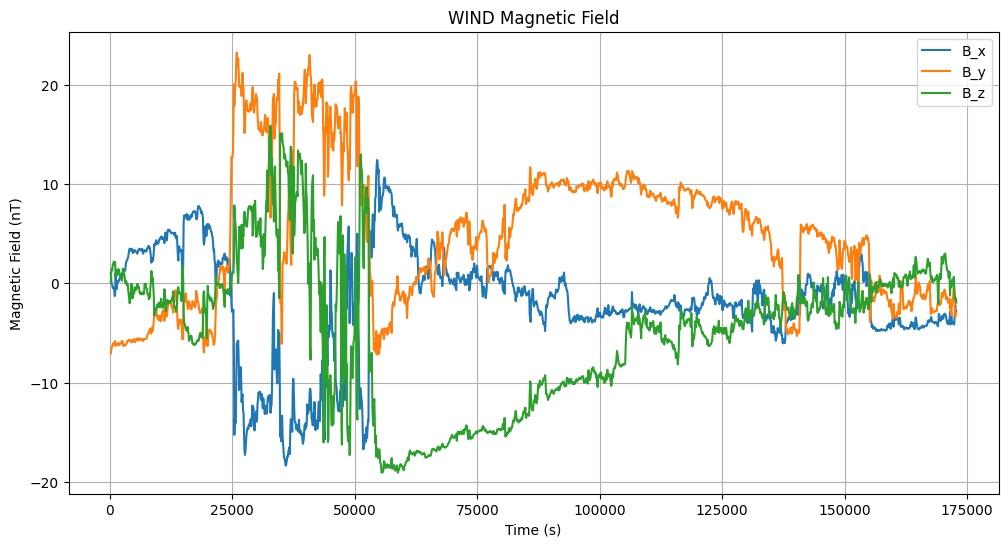

In [6]:
df_wind_resampled[["time_sec", "B_x", "B_y", "B_z"]].plot(x="time_sec", y=["B_x", "B_y", "B_z"], title="WIND Magnetic Field", xlabel="Time (s)", ylabel="Magnetic Field (nT)", figsize=(12, 6), grid=True)
plt.show()

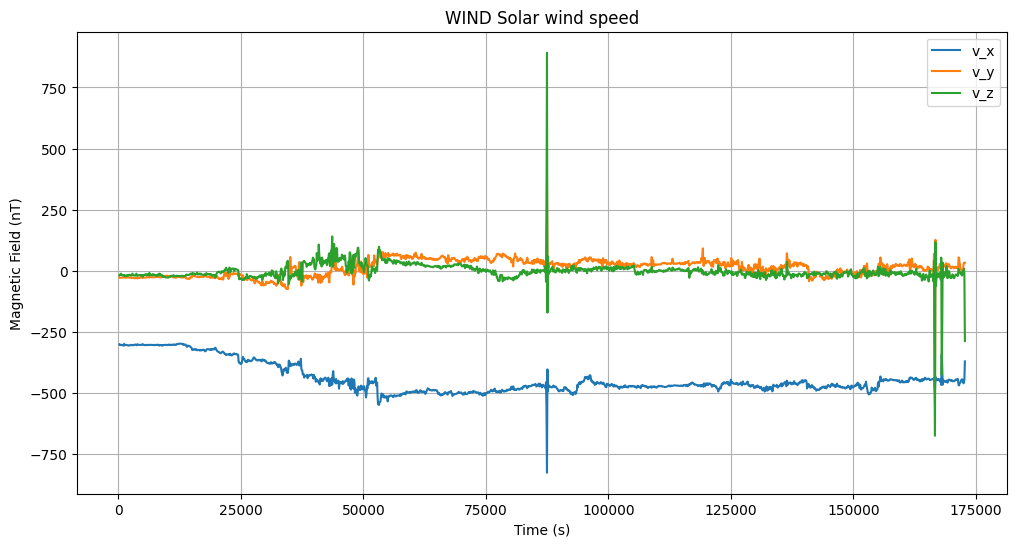

In [7]:
df_wind_resampled[["time_sec", "v_x", "v_y", "v_z"]].plot(x="time_sec", y=["v_x", "v_y", "v_z"], title="WIND Solar wind speed", xlabel="Time (s)", ylabel="Magnetic Field (nT)", figsize=(12, 6), grid=True)
plt.show()

In [8]:
df_wind_resampled["v_x"].isna().sum(), df_wind_resampled["v_y"].isna().sum(), df_wind_resampled["v_z"].isna().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [9]:
# Apply a low-pass filter to the data, in both directions to get rid of phase , using filtfilt
# The low-pass filter is a Butterworth filter, which is a type of filter that has a maximally flat frequency response in the passband.
def low_pass_filter(time_series, cutoff_freq, sampling_rate):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(N=1, Wn=normal_cutoff, btype="low", analog=False)
    return filtfilt(b=b, a=a, x=time_series)

sampling_rate = 1 / (df_wind_resampled["time_sec"][1] - df_wind_resampled["time_sec"][0])
cutoff_freq = 0.03 * sampling_rate
df_wind_resampled["B_x_filtered"] = low_pass_filter(df_wind_resampled["B_x"], cutoff_freq, sampling_rate)
df_wind_resampled["B_y_filtered"] = low_pass_filter(df_wind_resampled["B_y"], cutoff_freq, sampling_rate)
df_wind_resampled["B_z_filtered"] = low_pass_filter(df_wind_resampled["B_z"], cutoff_freq, sampling_rate)

In [10]:
def convert_time_to_days(hours, minutes = 0, seconds = 0):
    return (hours * SEC_TO_HOURS + minutes * 60 + seconds) / SEC_TO_DAYS


t_1 = convert_time_to_days(hours=15, minutes=7)
t_2 = 1 + convert_time_to_days(hours=18, minutes=0)

print(f"Initial time: {t_1:.5f} days, final time: {t_2:.5f} days.")

Initial time: 0.62986 days, final time: 1.75000 days.


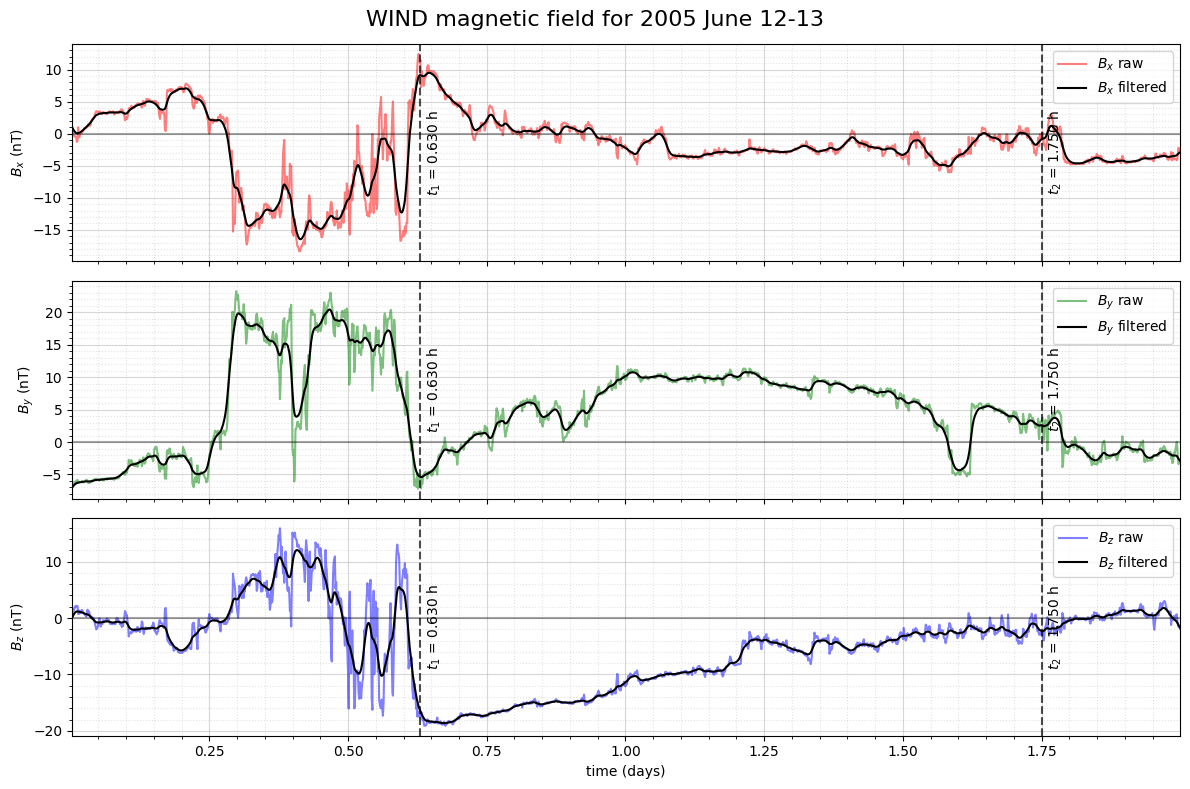

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True, tight_layout=True)
time_days = df_wind["time_sec"] / SEC_TO_DAYS
for axis, component, colour in zip(ax, ["x", "y", "z"], ["r", "g", "b"]):
    axis.plot(time_days, df_wind_resampled[f"B_{component}"], label=f"$B_{component}$ raw", c=colour, alpha=0.5)
    axis.plot(time_days, df_wind_resampled[f"B_{component}_filtered"], label=f"$B_{component}$ filtered", c="k")
    axis.axvline(t_1, c="k", linestyle="--", alpha=0.7)
    axis.axvline(t_2, c="k", linestyle="--", alpha=0.7)

    y_lims = axis.get_ylim()
    axis.text(t_1 + 1e-2, np.mean(y_lims), f"$t_1$ = {t_1:.3f} h", rotation=90, color="k", va="center")
    axis.text(t_2 + 1e-2, np.mean(y_lims), f"$t_2$ = {t_2:.3f} h", rotation=90, color="k", va="center")

    axis.axhline(0, c="k", linestyle="-", alpha=0.35)

    axis.set_ylabel(f"$B_{component}$ (nT)")
    axis.legend()
    axis.set_xlim(time_days.min(), time_days.max())
    axis.grid(which="major", alpha=0.5)
    axis.grid(which="minor", alpha=0.35, linestyle=':')
    axis.minorticks_on()

plt.suptitle("WIND magnetic field for 2005 June 12-13", fontsize=16)
ax[2].set_xlabel("time (days)")

#plt.savefig("wind_magnetic_field.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
# Create interpolators for each column (except 'time')
interpolators = {}
for column in df_wind_resampled.columns:
    if column != "time_days":
        interpolators[column] = interp1d(
            df_wind_resampled['time_days'], df_wind_resampled[column], kind="cubic", fill_value="extrapolate"
        )

# Step 3: Generate interpolated rows at start and end
def make_row(t, interpolators):
    row = {'time_days': t}
    for col, interp_func in interpolators.items():
        row[col] = float(interp_func(t))
    return row

start_row = make_row(t_1, interpolators)
end_row = make_row(t_2, interpolators)

start_row

{'time_days': 0.6298611111111111,
 'B': 21.65770839059089,
 'B_x': 11.559449996546311,
 'B_y': -5.822500449656993,
 'B_z': -17.284659868306036,
 'B_theta': -53.15164026098518,
 'B_phi': 333.7950151151528,
 'v_x': -513.5858597948016,
 'v_y': 71.76258700047904,
 'v_z': 40.849250038633464,
 'N_p': 15.81131570384816,
 'time_sec': 54419.999999999985,
 'B_x_filtered': 8.366659585391005,
 'B_y_filtered': -4.978936842989205,
 'B_z_filtered': -15.010211850545366}

In [13]:
# Filter the data for the event by time
df_interior = df_wind_resampled.loc[(df_wind_resampled["time_days"] > t_1) & (df_wind_resampled["time_days"] < t_2)].reset_index(drop=True)

df_event = pd.concat([
    pd.DataFrame([start_row]),
    df_interior,
    pd.DataFrame([end_row])
], ignore_index=True)

df_event["time_sec"] = df_event["time_days"] * SEC_TO_DAYS
df_event["time"] = df_event["time_sec"] - df_event["time_sec"][0]
print("Number of data points in the event:", len(df_event))
df_event.head()

Number of data points in the event: 985


,time_days,B,B_x,B_y,B_z,B_theta,B_phi,v_x,v_y,v_z,N_p,time_sec,B_x_filtered,B_y_filtered,B_z_filtered,time
0,0.629861,21.657708,11.559450,-5.822500,-17.284660,-53.151640,333.795015,-513.585860,71.762587,40.849250,15.811316,54420.000000,8.366660,-4.978937,-15.010212,0.000000
1,0.630439,21.712432,11.965918,-7.183984,-16.594657,-49.921468,329.085750,-516.210387,72.892705,33.533067,15.013557,54469.889534,8.565446,-5.061560,-15.227550,49.889534
2,0.631579,21.780109,12.440315,-6.408026,-16.670707,-50.002552,332.738282,-518.302005,56.188968,38.798544,16.301396,54568.384740,8.867162,-5.186484,-15.615260,148.384740
3,0.632719,21.737608,12.042707,-5.829304,-17.108578,-51.975914,334.185007,-518.343404,61.906916,31.670579,15.573444,54666.879946,9.047876,-5.265576,-15.961644,246.879946
4,0.633859,21.568725,11.090071,-5.592568,-17.616872,-54.807133,333.261806,-512.387981,64.355903,44.693996,13.652335,54765.375152,9.125588,-5.321254,-16.266029,345.375152


In [14]:
df_event = df_event.drop(["B_x", "B_y", "B_z"], axis=1)
df_event = df_event.rename(columns={"B_x_filtered": "B_x", "B_y_filtered": "B_y", "B_z_filtered": "B_z"})
df_event.head()

,time_days,B,B_theta,B_phi,v_x,v_y,v_z,N_p,time_sec,B_x,B_y,B_z,time
0,0.629861,21.657708,-53.151640,333.795015,-513.585860,71.762587,40.849250,15.811316,54420.000000,8.366660,-4.978937,-15.010212,0.000000
1,0.630439,21.712432,-49.921468,329.085750,-516.210387,72.892705,33.533067,15.013557,54469.889534,8.565446,-5.061560,-15.227550,49.889534
2,0.631579,21.780109,-50.002552,332.738282,-518.302005,56.188968,38.798544,16.301396,54568.384740,8.867162,-5.186484,-15.615260,148.384740
3,0.632719,21.737608,-51.975914,334.185007,-518.343404,61.906916,31.670579,15.573444,54666.879946,9.047876,-5.265576,-15.961644,246.879946
4,0.633859,21.568725,-54.807133,333.261806,-512.387981,64.355903,44.693996,13.652335,54765.375152,9.125588,-5.321254,-16.266029,345.375152


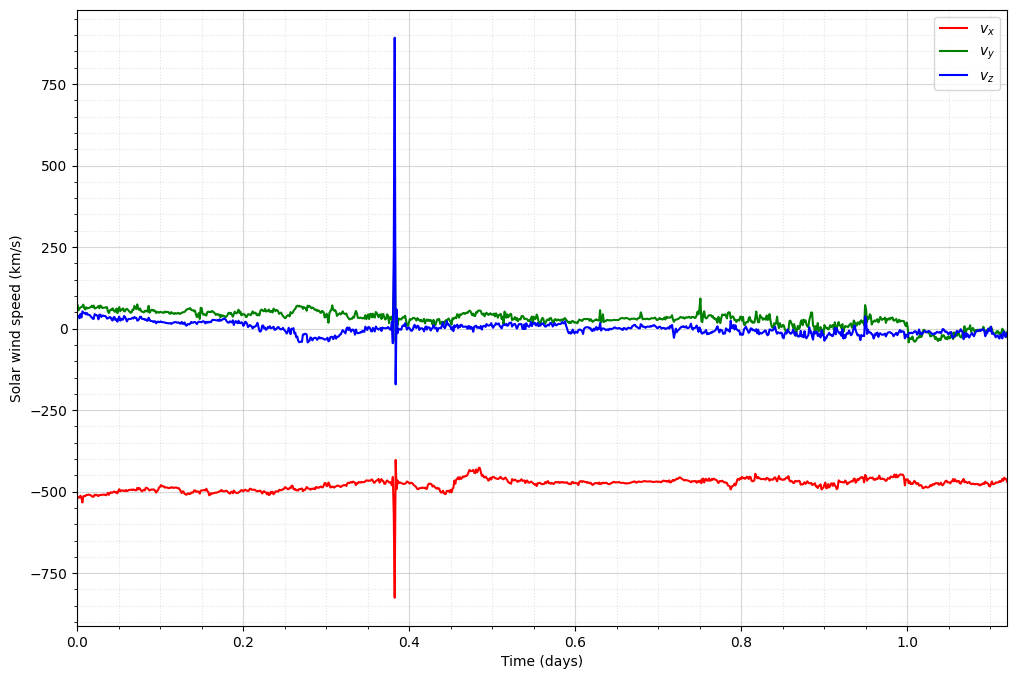

In [15]:
# Explore the solar wind speed data
def plot_solar_wind_speed(df_event: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(12, 8))
    time_days = df_event["time"] / SEC_TO_DAYS
    ax.plot(time_days, df_event["v_x"], label="$v_x$", color="red")
    ax.plot(time_days, df_event["v_y"], label="$v_y$", color="green")
    ax.plot(time_days, df_event["v_z"], label="$v_z$", color="blue")

    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Solar wind speed (km/s)")

    ax.set_xlim(time_days.min(), time_days.max())

    ax.legend()
    ax.grid(which="major", alpha=0.5)
    ax.grid(which="minor", alpha=0.35, linestyle=':')
    ax.minorticks_on()

    plt.show()

plot_solar_wind_speed(df_event)

In [16]:
from scipy.stats import zscore

for speed_column in ["v_x", "v_y", "v_z"]:
    Q1 = np.percentile(df_event[speed_column], 25)
    Q3 = np.percentile(df_event[speed_column], 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (df_event[speed_column] < lower_bound) | (df_event[speed_column] > upper_bound)

    v_bad_idx = np.where(outliers)[0]
    print(v_bad_idx)

    # Prepare clean data (without the bad point)
    good_idx = df_event.index.drop(v_bad_idx)
    good_values = df_event.loc[good_idx, speed_column]

    # Build interpolator only with good data
    interpolator = interp1d(
        good_idx,
        good_values,
        kind="linear",
        fill_value="extrapolate"
    )
    # Set the bad value to interpolated value
    df_event.loc[v_bad_idx, speed_column] = interpolator(v_bad_idx)

[  6 335 336 337 422 425 426]
[335 336 337 659 760 879 880 881 882 883 884 885 886 887 888 889 890 892
 893 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918
 919 920 921 922 923 926 928 930 933 934 935 981 982]
[  6   7   9  11 335 336 337 338]


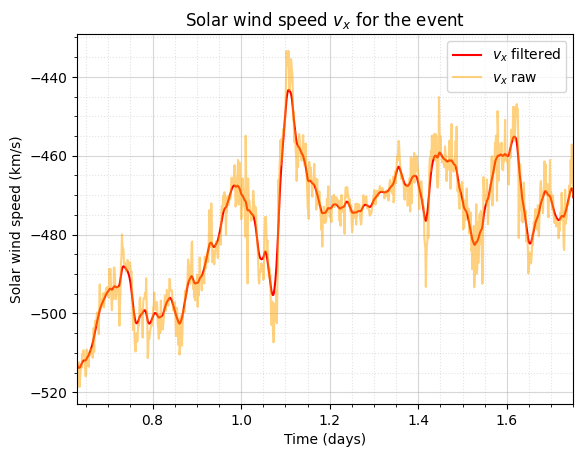

In [17]:
sampling_rate = 1 / (df_event["time_sec"][1] - df_event["time_sec"][0])
cutoff_freq = 0.03 * sampling_rate

df_event["v_x_filtered"] = low_pass_filter(df_event["v_x"], cutoff_freq, sampling_rate)
df_event["v_y_filtered"] = low_pass_filter(df_event["v_y"], cutoff_freq, sampling_rate)
df_event["v_z_filtered"] = low_pass_filter(df_event["v_z"], cutoff_freq, sampling_rate)

plt.plot(df_event["time_days"], df_event["v_x_filtered"], label="$v_x$ filtered", color="red")
plt.plot(df_event["time_days"], df_event["v_x"], label="$v_x$ raw", color="orange", alpha=0.5)
plt.xlabel("Time (days)")
plt.ylabel("Solar wind speed (km/s)")
plt.title("Solar wind speed $v_x$ for the event")
plt.legend()
plt.grid(which="major", alpha=0.5)
plt.grid(which="minor", alpha=0.35, linestyle=':')
plt.minorticks_on()
plt.xlim(df_event["time_days"].min(), df_event["time_days"].max())
plt.show()

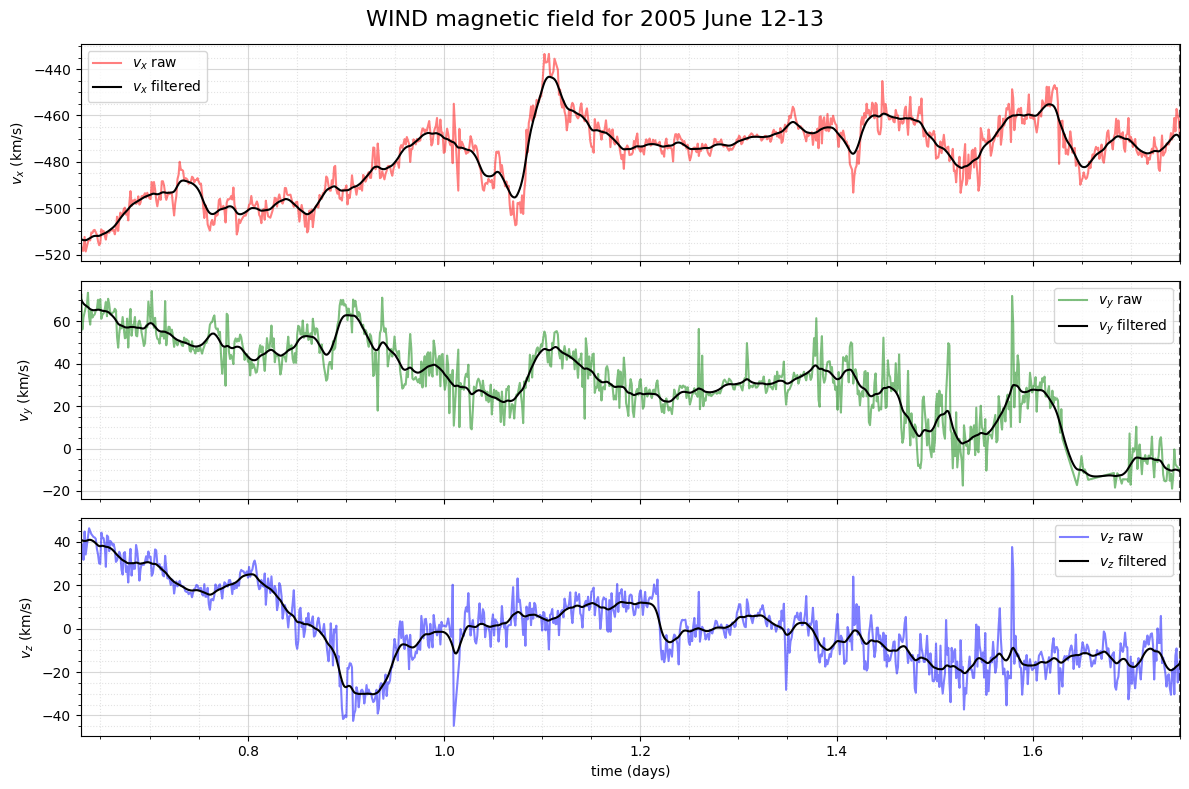

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True, tight_layout=True)
time_days = df_event["time_sec"] / SEC_TO_DAYS
for axis, component, colour in zip(ax, ["x", "y", "z"], ["r", "g", "b"]):
    axis.plot(time_days, df_event[f"v_{component}"], label=f"$v_{component}$ raw", c=colour, alpha=0.5)
    axis.plot(time_days, df_event[f"v_{component}_filtered"], label=f"$v_{component}$ filtered", c="k")
    axis.axvline(t_1, c="k", linestyle="--", alpha=0.7)
    axis.axvline(t_2, c="k", linestyle="--", alpha=0.7)

    # axis.axhline(0, c="k", linestyle="-", alpha=0.35)

    axis.set_ylabel(f"$v_{component}$ (km/s)")
    axis.legend()
    axis.set_xlim(time_days.min(), time_days.max())
    axis.grid(which="major", alpha=0.5)
    axis.grid(which="minor", alpha=0.35, linestyle=':')
    axis.minorticks_on()

plt.suptitle("WIND magnetic field for 2005 June 12-13", fontsize=16)
ax[2].set_xlabel("time (days)")

plt.savefig("solar_wind_velocity.png", dpi=150, bbox_inches="tight")
plt.show()

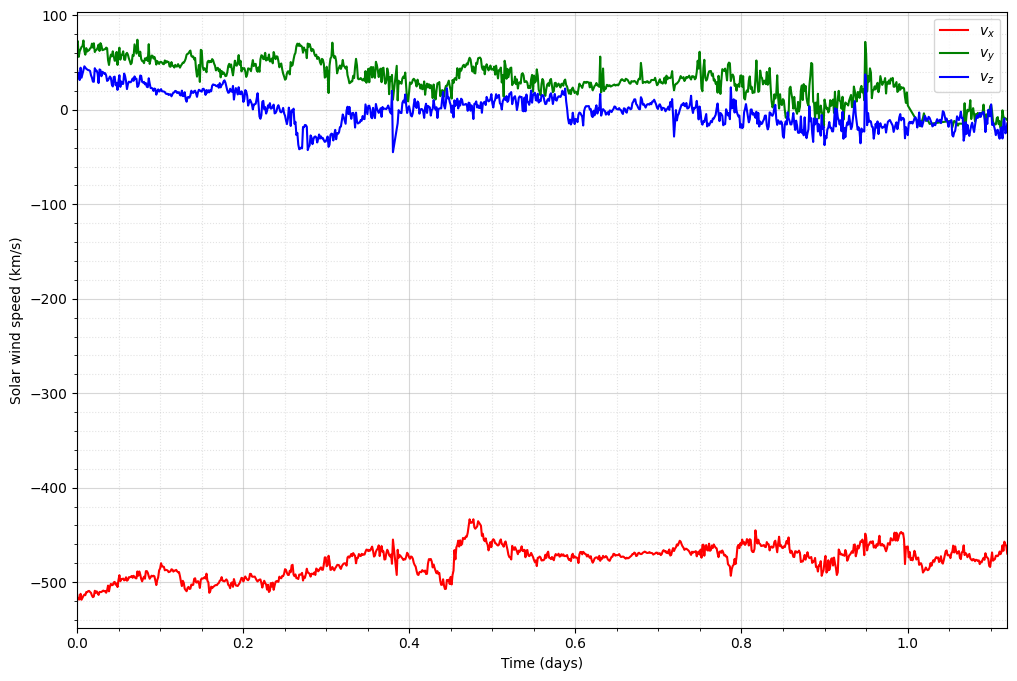

In [19]:
plot_solar_wind_speed(df_event)

In [20]:
speeds = df_event[["v_x", "v_y", "v_z"]].values
v_sw = np.mean(np.sqrt(np.sum(speeds**2, axis=1)))
v_sw

np.float64(479.3787315022925)

In [21]:
speeds_filtered = df_event[["v_x_filtered", "v_y_filtered", "v_z_filtered"]].values
v_sw_filtered = np.sqrt(np.sum(speeds_filtered**2, axis=1))
v_sw_filtered_mean = np.mean(v_sw_filtered)
v_sw_filtered_mean

np.float64(479.2745264126587)

In [22]:
N = len(df_event)
w = 20
v_lead = np.mean(df_event["v_x_filtered"][:w])  # average around front boundary
v_trail = np.mean(df_event["v_x_filtered"][N-w:])  # average around rear boundary

v_expansion = 0.5 * (abs(v_lead) - abs(v_trail))
v_expansion

np.float64(20.729304850023453)

In [23]:
# DiP
def calculate_dip(df_event: pd.DataFrame) -> float:
    B_x = df_event["B_x"].values
    B_y = df_event["B_y"].values
    B_z = df_event["B_z"].values

    # Calculate the magnitude of the magnetic field vector
    B_magnitude = np.sqrt(B_x**2 + B_y**2 + B_z**2)
    normalised_time = (df_event["time_sec"] - df_event["time_sec"].min()) / (df_event["time_sec"].max() - df_event["time_sec"].min())
    print(normalised_time[0], normalised_time[len(normalised_time)-1])
    DiP = np.sum(B_magnitude*normalised_time) / np.sum(B_magnitude)

    return DiP

DiP = calculate_dip(df_event)
print(f"DiP: {DiP:.3f}")

0.0 1.0
DiP: 0.394


In [24]:
def calculate_B_mean(df_event: pd.DataFrame) -> float:
    B_x = df_event["B_x"].values
    B_y = df_event["B_y"].values
    B_z = df_event["B_z"].values

    # Calculate the magnitude of the magnetic field vector
    B_magnitude = np.sqrt(B_x**2 + B_y**2 + B_z**2)
    return np.mean(B_magnitude)

B_mean = calculate_B_mean(df_event)
print(f"B_mean: {B_mean:.3f} nT")

B_mean: 12.178 nT


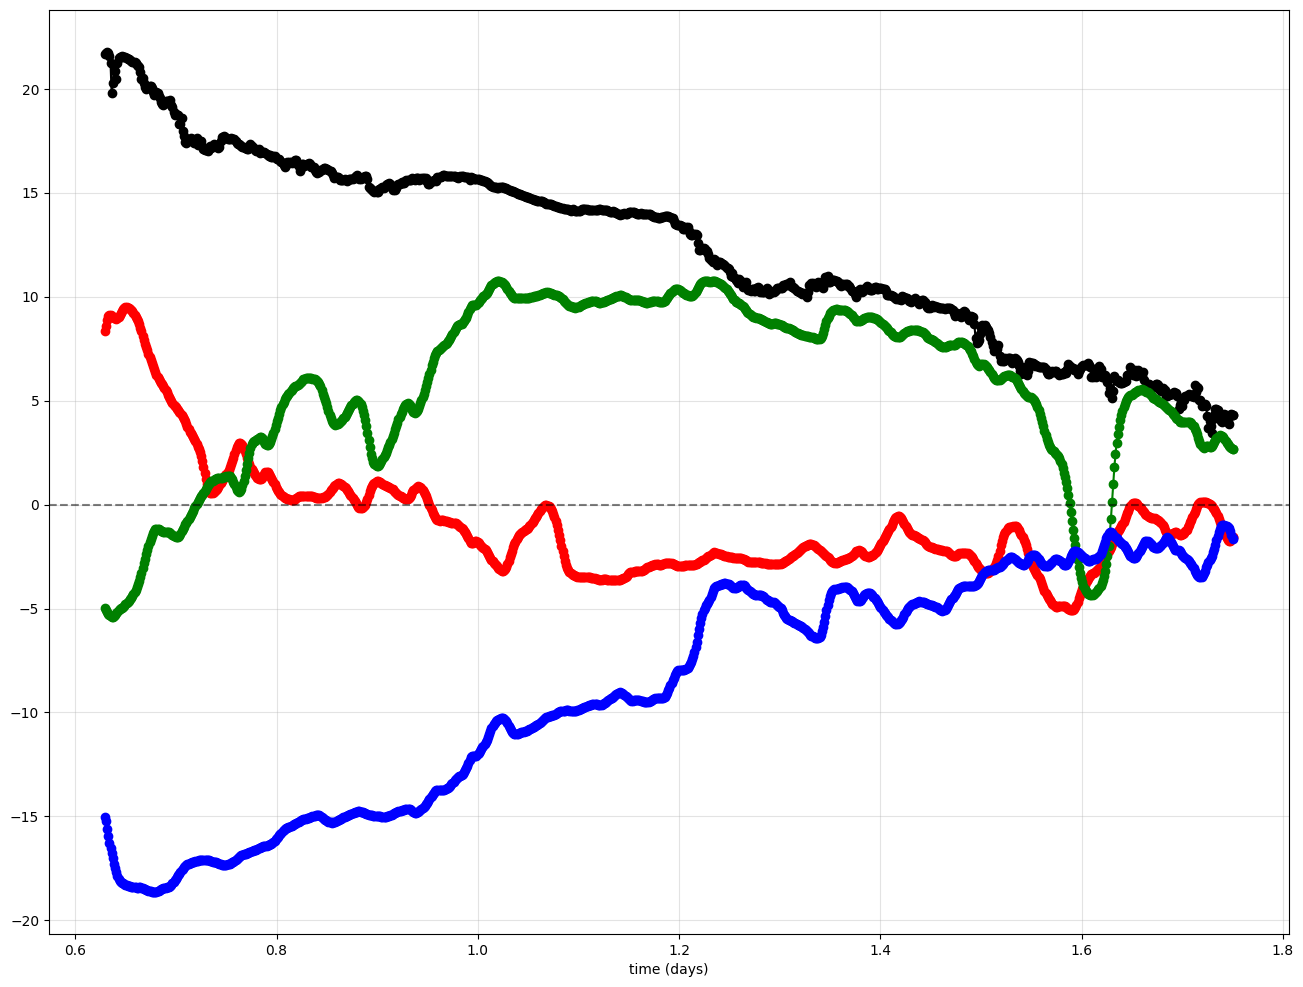

In [25]:
def plot_event(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.plot(df["time_days"], df["B"], "-ok")
    ax.plot(df["time_days"], df["B_x"], "-or")
    ax.plot(df["time_days"], df["B_y"], "-og")
    ax.plot(df["time_days"], df["B_z"], "-ob")
    ax.axhline(0, linestyle="--", color="k", alpha=0.5)
    ax.set_xlabel("time (days)")
    ax.grid(alpha=0.35)

plot_event(df_event)

In [26]:
df_event["time_sec"][0]

np.float64(54420.0)

In [27]:
window_size = 20

# Apply rolling mean
df_rolling = df_event.rolling(window=window_size, center=True).mean()
df_rolling = df_rolling.iloc[::window_size].dropna().reset_index(drop=True)
df_rolling.head()

,time_days,B,B_theta,B_phi,v_x,v_y,v_z,N_p,time_sec,B_x,B_y,B_z,time,v_x_filtered,v_y_filtered,v_z_filtered
0,0.651528,21.334376,-60.381771,333.072417,-511.128196,65.344708,38.800495,15.787954,56292.050846,9.228022,-4.646847,-18.245428,1872.050846,-510.990300,64.819015,38.284456
1,0.674328,20.053251,-68.579491,310.293662,-502.212275,57.768867,30.735315,14.367855,58261.954967,7.105840,-2.015283,-18.544128,3841.954967,-502.458606,58.257799,31.776109
2,0.697128,18.891381,-73.826286,342.526021,-494.873699,57.935724,31.037783,14.170364,60231.859088,4.912122,-1.376204,-18.086700,5811.859088,-495.081029,57.585245,30.094414
3,0.719928,17.384950,-79.914010,225.174916,-493.017045,53.337092,23.879575,18.805264,62201.763209,2.789627,-0.053456,-17.175400,7781.763209,-492.582797,53.686421,24.064301
4,0.742728,17.394005,-84.153469,73.494209,-487.665537,48.147192,17.840175,14.624568,64171.667330,1.009443,1.240447,-17.240401,9751.667330,-490.062736,49.105560,18.002315


In [28]:
df_event_downsampled = pd.concat([
    df_event.iloc[[0]],          # First row as DataFrame
    df_rolling.iloc[1:-1],       # Rolling-averaged middle rows
    df_event.iloc[[-1]]          # Last row as DataFrame
], ignore_index=False).reset_index(drop=True)

df_event_downsampled.head()

,time_days,B,B_theta,B_phi,v_x,v_y,v_z,N_p,time_sec,B_x,B_y,B_z,time,v_x_filtered,v_y_filtered,v_z_filtered
0,0.629861,21.657708,-53.151640,333.795015,-513.585860,71.762587,40.849250,15.811316,54420.000000,8.366660,-4.978937,-15.010212,0.000000,-512.944064,71.404771,41.394425
1,0.674328,20.053251,-68.579491,310.293662,-502.212275,57.768867,30.735315,14.367855,58261.954967,7.105840,-2.015283,-18.544128,3841.954967,-502.458606,58.257799,31.776109
2,0.697128,18.891381,-73.826286,342.526021,-494.873699,57.935724,31.037783,14.170364,60231.859088,4.912122,-1.376204,-18.086700,5811.859088,-495.081029,57.585245,30.094414
3,0.719928,17.384950,-79.914010,225.174916,-493.017045,53.337092,23.879575,18.805264,62201.763209,2.789627,-0.053456,-17.175400,7781.763209,-492.582797,53.686421,24.064301
4,0.742728,17.394005,-84.153469,73.494209,-487.665537,48.147192,17.840175,14.624568,64171.667330,1.009443,1.240447,-17.240401,9751.667330,-490.062736,49.105560,18.002315


In [29]:
df_event_downsampled.tail()

,time_days,B,B_theta,B_phi,v_x,v_y,v_z,N_p,time_sec,B_x,B_y,B_z,time,v_x_filtered,v_y_filtered,v_z_filtered
43,1.63192,5.847731,-13.575419,164.070963,-465.976405,4.970012,-13.899843,4.276225,140997.928049,-1.730833,0.906641,-1.677071,86577.928049,-467.021169,5.348549,-13.963749
44,1.65472,6.191054,-21.774184,89.336550,-482.017215,-12.582363,-11.890361,3.298097,142967.832170,-0.194962,5.370902,-2.221306,88547.832170,-480.024814,-11.564138,-11.915392
45,1.67752,5.554296,-18.342677,101.774423,-471.492614,-12.927213,-13.534465,3.774861,144937.736291,-0.942254,4.925897,-1.868787,90517.736291,-472.230963,-12.872345,-12.958878
46,1.70032,5.156783,-28.514261,107.979107,-471.812762,-7.669774,-16.418383,3.954632,146907.640412,-1.195693,4.044047,-2.451634,92487.640412,-471.856407,-7.760844,-15.767247
47,1.75000,4.298984,-35.568183,125.985086,-469.840162,-10.562153,-14.283217,4.436596,151200.000000,-1.559697,2.656357,-1.645407,96780.000000,-470.543983,-10.875190,-15.193161


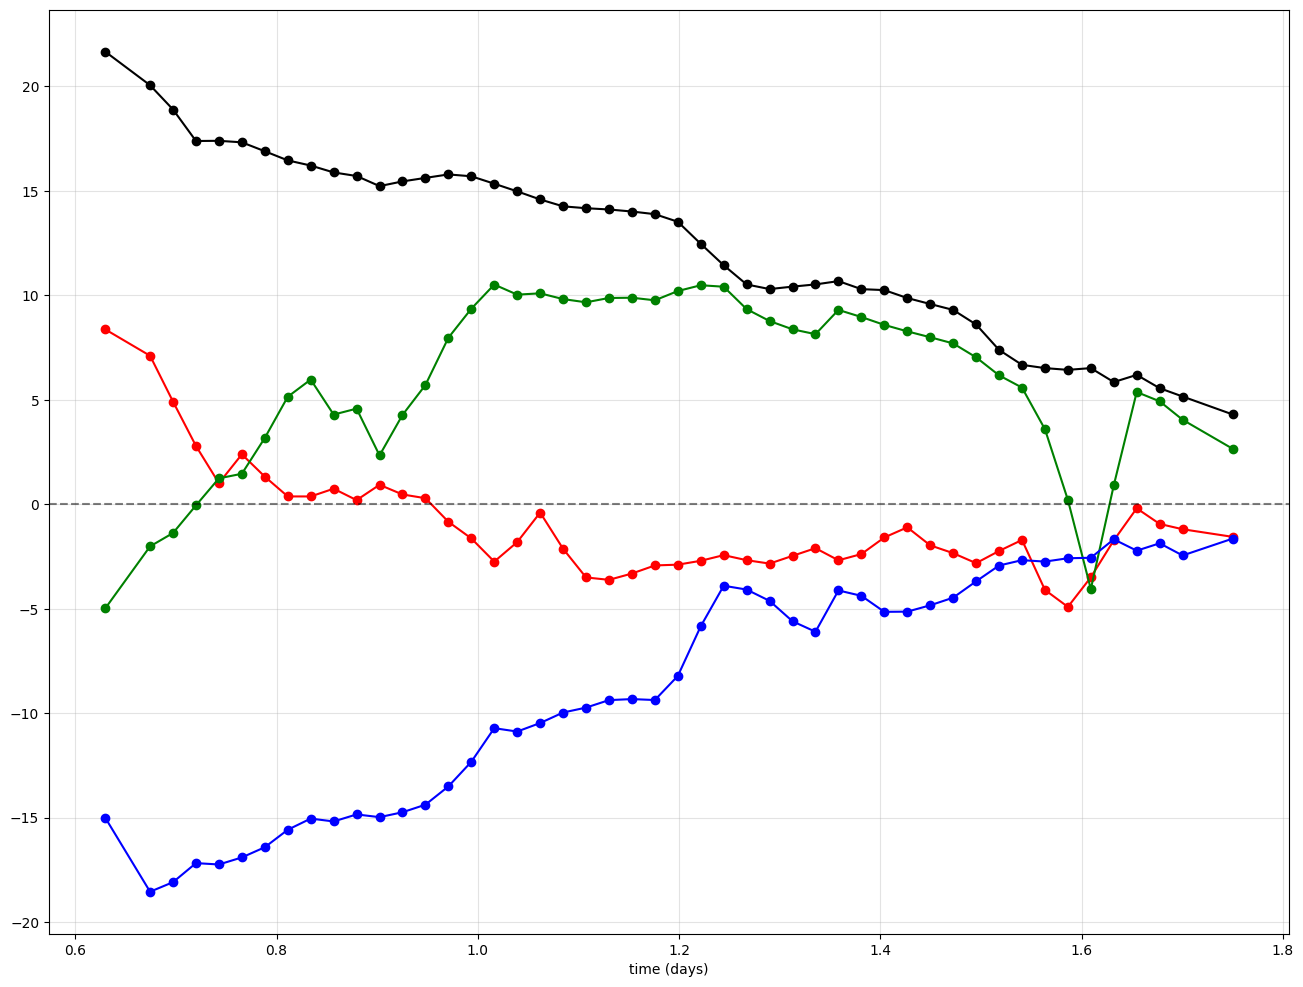

In [30]:
plot_event(df_event_downsampled)

In [61]:
time_delta_total = df_event["time"].max() - df_event["time"].min()
total_distance_travelled = v_sw * 1000 * time_delta_total

AU_to_m = 149_597_870_700.0
print(f"Time delta total: {time_delta_total / 3600:.3f} h")
print(f"Distance travelled in MFR: {total_distance_travelled / AU_to_m:.4f} AU")

Time delta total: 26.883 h
Distance travelled in MFR: 0.3101 AU


In [ ]:
model_params = {
    "delta": {"mode": "fixed", "value": 1.0},
    "R": {"mode": "fixed", "value": 1.0},
    #"delta": {"mode": "optimised", "initial_value": 0.4, "bounds": [0.3, 1]},
    "psi": {"mode": "fixed", "value": 0},
    #"psi": {"mode": "optimised", "initial_value": math.radians(45), "bounds": [0.01, math.radians(180)*0.99]},
    "tau": {"mode": "fixed", "value": 1.0},
    "C_nm": {"mode": "optimised", "initial_value": 1.5, "bounds": [0.5, 3]}, #[0.15, 3]
    "B_z_0": {"mode": "optimised", "initial_value": 15.0, "bounds": [10, 20]},
    "handedness": {"mode": "fixed", "value": -1},
    }

crossing_params = {
    "y_0": {"mode": "optimised", "initial_value": 0.0, "bounds": [-0.65, 0.65]},
    "v_sc": {"mode": "fixed", "value": v_sw},
    "gamma": {"mode": "optimised", "initial_value": math.radians(0), "bounds": [-math.radians(85), math.radians(85)]},
    "theta": {"mode": "optimised", "initial_value": math.radians(0), "bounds": [-math.radians(80), math.radians(80)]},
    "time_stencil": {"mode": "fixed", "value": df_event["time"]},
    }

fitted_model, fitted_model_parameters,fitted_crossing_parameters, df_fitted, info = ECModel.fit(ECModel, df_event_downsampled, model_params, crossing_params, residue_method="RMSE")

print("-> Fitted model:")
print(fitted_model)

print("-> Fitted crossing parameters:")
print(fitted_crossing_parameters)

print("-> Theta (deg): ", math.degrees(fitted_crossing_parameters["theta"]))

print("-> Info:")
print(info)

print("-> Opt. fun.: ", info["f_opt"])

-> Fitted model:
ECModel with parameters:
        - Geometrical:
            - delta = 1.000
            - psi = 0.000 deg
            - R = 1.000 AU
        - Field:
            - n = 1
            - m = 0
            - tau = 1.000
            - C_10 = 1.706
            - B_z_0 = 16.108 nT
            - handedness = 1.
-> Fitted crossing parameters:
{'y_0': np.float64(0.42716932698882165), 'gamma': np.float64(-0.7748820246656863), 'theta': np.float64(-0.5188644421120596), 'v_sc': np.float64(479.3787315022925), 'time_stencil': array([    0.        ,  3841.95496661,  5811.85908761,  7781.76320862,
        9751.66732962, 11721.57145063, 13691.47557163, 15661.37969264,
       17631.28381364, 19601.18793465, 21571.09205565, 23540.99617666,
       25510.90029766, 27480.80441866, 29450.70853967, 31420.61266067,
       33390.51678168, 35360.42090268, 37330.32502369, 39300.22914469,
       41270.1332657 , 43240.0373867 , 45209.94150771, 47179.84562871,
       49149.74974971, 51119.65387072, 53

In [48]:
# MFR orientation angles
gamma_deg = 180 + math.degrees(fitted_crossing_parameters["gamma"])
theta_deg = math.degrees(fitted_crossing_parameters["theta"])

print(f"-> MFR orientation angles: gamma = {gamma_deg:.2f} deg, theta = {theta_deg:.2f} deg")

-> MFR orientation angles: gamma = 135.60 deg, theta = -29.73 deg


In [58]:
# Calculate the radius
y_0_cc = fitted_crossing_parameters["y_0"]
y_0_cc

np.float64(0.42716932698882165)

In [62]:
R_cc = total_distance_travelled / (2 * math.sqrt(1-y_0_cc**2))
R_cc / AU_to_m

np.float64(0.17149761626285406)

In [51]:
from MagneticFluxRopeModels.MagneticFluxRopeUtils import compute_intermediate_variance_axis

B_field = df_event[["B_x", "B_y", "B_z"]].to_numpy()
e_z_intermediate_variance = compute_intermediate_variance_axis(B_field)
print(f"Intermediate variance axis: {e_z_intermediate_variance}")

theta_intermediate_variance = np.acos(e_z_intermediate_variance[2])
print(f"Intermediate variance theta: {math.degrees(theta_intermediate_variance)}")

gamma_intermediate_variance = np.asin(e_z_intermediate_variance[0] / math.sin(theta_intermediate_variance))
print(f"Intermediate variance gamma: {math.degrees(gamma_intermediate_variance)}")

Intermediate variance axis: [ 0.16744902 -0.84889682  0.50133324]
Intermediate variance theta: 59.91175409993925
Intermediate variance gamma: 11.158616980723824


In [36]:
gamma_intermediate_variance =  -math.acos(e_z_intermediate_variance[1] / math.sin(theta_intermediate_variance))
print(f"Intermediate variance gamma: {math.degrees(gamma_intermediate_variance)}")

Intermediate variance gamma: -168.84138301927618


In [37]:
fitted_crossing_parameters["y_0"]

np.float64(0.65)

In [ ]:
R_cc = 

0.6423357664233575

In [39]:
# Estimate the radius of the flux rope
fitted_crossing_parameters["v_sc"] * 1e3 * fitted_crossing_parameters["time_stencil"][-1] / (2*149_597_870_700.0)

np.float64(0.1550632820430641)

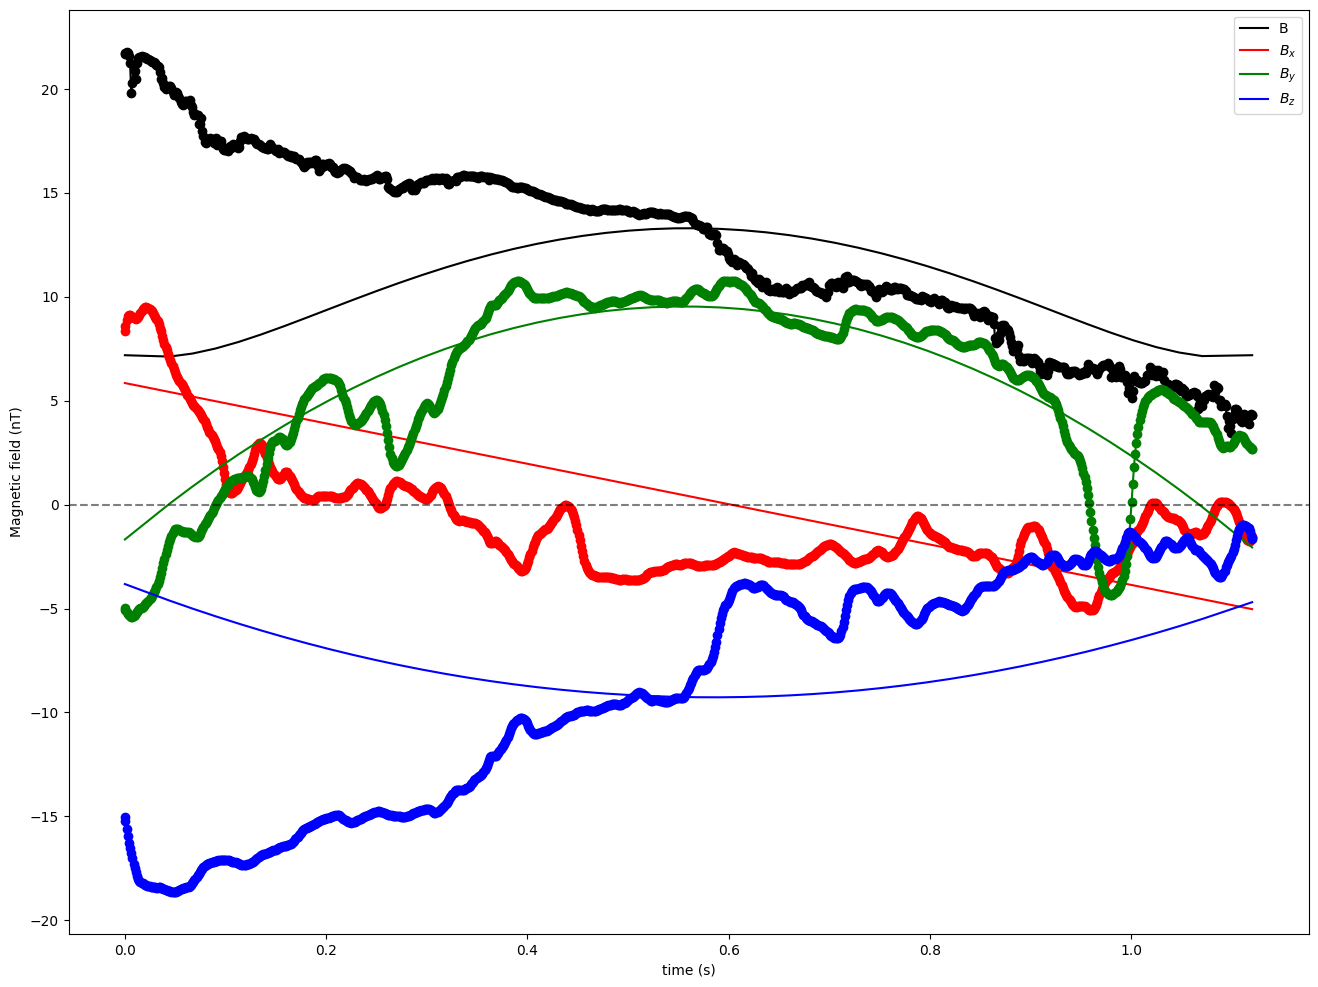

In [40]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(df_event["time"] / SEC_TO_DAYS, df_event["B"], "-ok")
ax.plot(df_fitted["time"] / SEC_TO_DAYS, df_fitted["B"], "-k", label="B")

ax.plot(df_event["time"] / SEC_TO_DAYS, df_event["B_x"], "-or")
ax.plot(df_fitted["time"] / SEC_TO_DAYS, df_fitted["B_x"], "-r", label="$B_x$")

ax.plot(df_event["time"] / SEC_TO_DAYS, df_event["B_y"], "-og")
ax.plot(df_fitted["time"] / SEC_TO_DAYS, df_fitted["B_y"], "-g", label="$B_y$")

ax.plot(df_event["time"] / SEC_TO_DAYS, df_event["B_z"], "-ob")
ax.plot(df_fitted["time"] / SEC_TO_DAYS, df_fitted["B_z"], "-b", label="$B_z$")

ax.axhline(0, linestyle="--", color="k", alpha=0.5)

ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("Magnetic field (nT)")

plt.show()

In [41]:
math.sqrt(np.mean((df_fitted["B_x"] - df_event["B_x"])**2 + (df_fitted["B_y"] - df_event["B_y"])**2 + (df_fitted["B_z"] - df_event["B_z"])**2))

16.93865045420102

In [42]:
info["f_opt"]

7.090224532347579

In [43]:
B_x_mean = df_event["B_x"].mean()
B_y_mean = df_event["B_y"].mean()
B_z_mean = df_event["B_z"].mean()
B_mod_mean = df_event["B"].mean()

SSTot = np.sum((df_event["B_x"] - B_x_mean)**2 + (df_event["B_y"] - B_y_mean)**2 + (df_event["B_z"] - B_z_mean)**2)
SSRes = np.sum((df_fitted["B_x"] - df_event["B_x"])**2 + (df_fitted["B_y"] - df_event["B_y"])**2 + (df_fitted["B_z"] - df_event["B_z"])**2)
R2 = 1 - SSRes / SSTot
rho = np.sqrt(R2)
print("-> R^2: ", R2)
print("-> R: ", rho)

-> R^2:  0.7564022902480789
-> R:  0.8697139128748481


In [44]:
R2_x = 1 - np.sum((df_fitted["B_x"] - df_event["B_x"])**2) / np.sum((df_event["B_x"] - B_x_mean)**2)
R2_y = 1 - np.sum((df_fitted["B_y"] - df_event["B_y"])**2) / np.sum((df_event["B_y"] - B_y_mean)**2)
R2_z = 1 - np.sum((df_fitted["B_z"] - df_event["B_z"])**2) / np.sum((df_event["B_z"] - B_z_mean)**2)
R2_mod = 1 - np.sum((df_fitted["B"] - df_event["B"])**2) / np.sum((df_event["B"] - B_mod_mean)**2)
print("-> R2_x: ", R2_x)
print("-> R2_y: ", R2_y)
print("-> R2_z: ", R2_z)
print("-> R2_mod: ", R2_mod)


-> R2_x:  0.5888793156712686
-> R2_y:  0.6974185444050225
-> R2_z:  0.833449091730434
-> R2_mod:  0.729218045484026


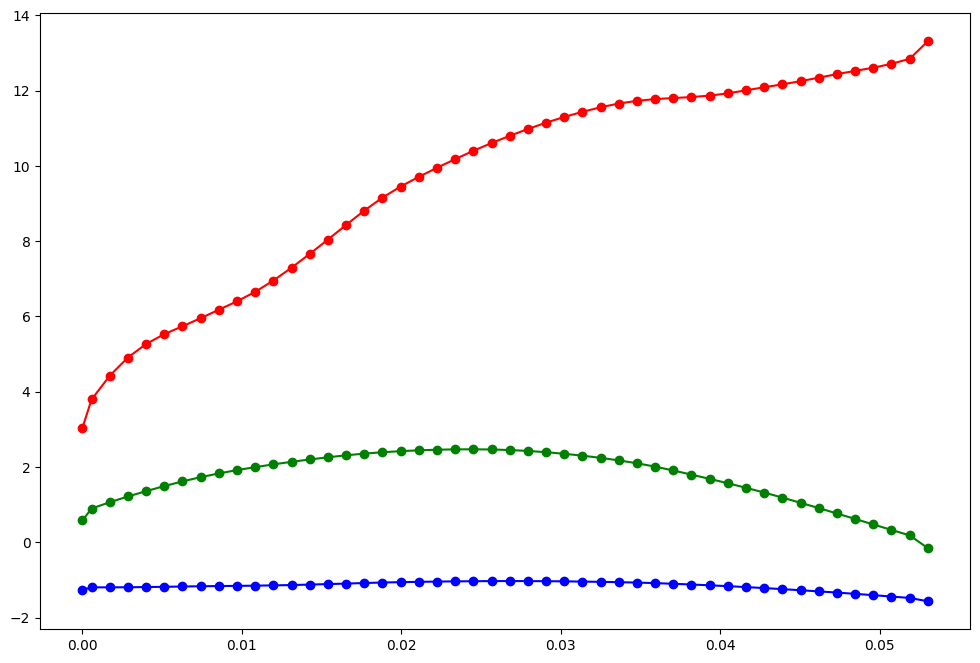

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_event["time"] / SEC_TO_DAYS, (df_fitted["B_x"] - df_event["B_x"]) / df_event["B_x"].mean(), "-or")
ax.plot(df_event["time"] / SEC_TO_DAYS, (df_fitted["B_y"] - df_event["B_y"]) / df_event["B_y"].mean(), "-og")
ax.plot(df_event["time"] / SEC_TO_DAYS, (df_fitted["B_z"] - df_event["B_z"]) / df_event["B_z"].mean(), "-ob")
plt.show()